In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from process_data import prepare_dataloader 
from sklearn.model_selection import StratifiedShuffleSplit
from training import train_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot as plt


In [2]:
batch_size=32
num_epochs=20
lr=0.001
patience=5

In [3]:
raw_data_dir = "./data/raw_data/COVID-19_Radiography_Dataset"
processed_data_dir = "./data/processed_data"
full_dataset = prepare_dataloader(
    raw_data_dir=raw_data_dir,
    processed_data_dir=processed_data_dir,
    batch_size=batch_size,
    include_masks=False,
    augment=True
)

# Extract labels from the dataset
labels = [item['label'] for item in full_dataset.data]  

# Perform stratified sampling
val_fraction = 0.2  # 20% validation data
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=42)

# Get train and validation indices
train_indices, val_indices = next(strat_split.split(range(len(full_dataset.data)), labels))

# Subset the dataset using the indices
train_dataset = Subset(full_dataset, train_indices)
# val_dataset = Subset(full_dataset, val_indices)

# Further split the validation dataset into valid and test subsets
test_strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

# Extract labels for the validation dataset
val_labels = [full_dataset.data[idx]['label'] for idx in val_indices]

# Perform stratified sampling within val_dataset
test_strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
test_indices_relative, valid_indices_relative = next(test_strat_split.split(range(len(val_indices)), val_labels))

# Map relative indices back to the original validation indices
test_indices = [val_indices[i] for i in test_indices_relative]
valid_indices = [val_indices[i] for i in valid_indices_relative]

# Create validation and test subsets
valid_dataset = Subset(full_dataset, valid_indices)
test_dataset = Subset(full_dataset, test_indices)



# Create DataLoader for all training and validation and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


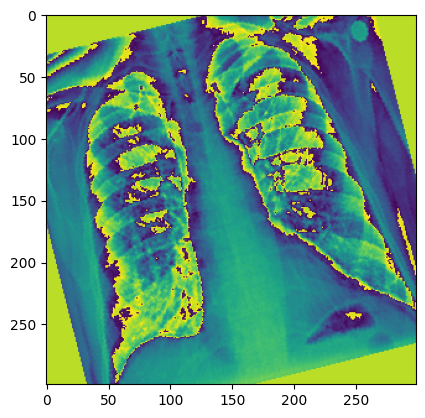

In [4]:
for image,lables in train_dataloader:
    plt.imshow(image[1][0])

    break

In [5]:
print("Training dataset Length:",len(train_dataloader.dataset))
print("Test dataset Length:",len(test_dataloader.dataset))
print("Validation dataset Length:",len(val_dataloader.dataset))

Training dataset Length: 16932
Test dataset Length: 2116
Validation dataset Length: 2117


### Demo : Load the best model

In [6]:
 # Re-initialize the model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\91958\anaconda3\envs\radiology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91958\anaconda3\envs\radiology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Load the model weights
model.load_state_dict(torch.load("./models/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

C:\Users\91958\AppData\Local\Temp\ipykernel_19108\2332179763.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/best_model.pth", 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the given dataloader and compute metrics.

    Parameters:
    model (torch.nn.Module): The trained model.
    dataloader (DataLoader): DataLoader for evaluation.
    device (torch.device): The device to run the model on.

    Returns:
    dict: A dictionary containing accuracy, precision, recall, and F1 score.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# Evaluate the model
metrics = evaluate_model(model, val_dataloader, device)
print(f"Evaluation Metrics for Validation Dataset:\n"
        f"Accuracy: {metrics['accuracy']:.4f}\n"
        f"Precision: {metrics['precision']:.4f}\n"
        f"Recall: {metrics['recall']:.4f}\n"
        f"F1 Score: {metrics['f1_score']:.4f}")


  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [00:33<00:00,  1.99it/s]

Evaluation Metrics for Validation Dataset:
Accuracy: 0.9924
Precision: 0.9925
Recall: 0.9924
F1 Score: 0.9924


In [11]:
# Evaluate the model
metrics = evaluate_model(model, train_dataloader, device)
print(f"Evaluation Metrics for Training Dataset:\n"
        f"Accuracy: {metrics['accuracy']:.4f}\n"
        f"Precision: {metrics['precision']:.4f}\n"
        f"Recall: {metrics['recall']:.4f}\n"
        f"F1 Score: {metrics['f1_score']:.4f}")

100%|██████████| 530/530 [03:08<00:00,  2.81it/s]


Evaluation Metrics for Training Dataset:
Accuracy: 0.9946
Precision: 0.9946
Recall: 0.9946
F1 Score: 0.9946


In [12]:
# Evaluate the model
metrics = evaluate_model(model, test_dataloader, device)
print(f"Evaluation Metrics for Test Dataset:\n"
        f"Accuracy: {metrics['accuracy']:.4f}\n"
        f"Precision: {metrics['precision']:.4f}\n"
        f"Recall: {metrics['recall']:.4f}\n"
        f"F1 Score: {metrics['f1_score']:.4f}")

100%|██████████| 67/67 [00:22<00:00,  2.99it/s]

Evaluation Metrics for Test Dataset:
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F1 Score: 0.9939
